In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Dense,BatchNormalization,Dropout, SimpleRNN, Embedding, LSTM, ConvLSTM2D, Flatten, BatchNormalization, Conv1D, Conv2D
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.optimizers import Adam,SGD
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import datetime
import tensorflow as tf
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
!unzip occupancy_data.zip

--2020-12-23 22:09:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335713 (328K) [application/x-httpd-php]
Saving to: ‘occupancy_data.zip’

occupancy_data.zip  100%[===================>] 327.84K  1.15MB/s    in 0.3s    

2020-12-23 22:09:09 (1.15 MB/s) - ‘occupancy_data.zip’ saved [335713/335713]

Archive:  occupancy_data.zip
  inflating: datatest.txt            
  inflating: datatest2.txt           
  inflating: datatraining.txt        


## Load the dataset



In [ ]:
data = pd.read_csv("datatraining.txt",engine='python')
data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [ ]:
data.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


## Preproccesing

In [ ]:
data['Date']=pd.to_datetime(data['date']).dt.date
data['Time']=pd.to_datetime(data['date']).dt.time
data.drop(columns='date',inplace=True)
data=data.set_index(data['Date'])
data.drop(columns='Date',inplace=True)
data.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Time
Date,,,,,,,
2015-02-04,23.18,27.2720,426.0,721.25,0.004793,1,17:51:00
2015-02-04,23.15,27.2675,429.5,714.00,0.004783,1,17:51:59
2015-02-04,23.15,27.2450,426.0,713.50,0.004779,1,17:53:00
2015-02-04,23.15,27.2000,426.0,708.25,0.004772,1,17:54:00
2015-02-04,23.10,27.2000,426.0,704.50,0.004757,1,17:55:00


In [ ]:
data.dtypes
print(data.count())

Temperature      8143
Humidity         8143
Light            8143
CO2              8143
HumidityRatio    8143
Occupancy        8143
Time             8143
dtype: int64


(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.]),
 <a list of 7 Text major ticklabel objects>)

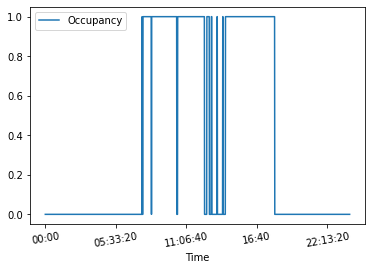

In [ ]:
day = data.loc[datetime.date(year=2015,month=2,day=5)]
day.plot('Time','Occupancy')
plt.xticks(rotation=10)

In [ ]:
columns_to_scale = ['Temperature','Humidity','Light','CO2','HumidityRatio']
scaler = StandardScaler().fit(data[columns_to_scale].to_numpy())
data.loc[:,columns_to_scale] = scaler.transform(data[columns_to_scale].to_numpy())
data.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Time
Date,,,,,,,
2015-02-04,2.518470,0.278526,1.573763,0.364948,1.091757,1,17:51:00
2015-02-04,2.488967,0.277713,1.591735,0.341881,1.080555,1,17:51:59
2015-02-04,2.488967,0.273645,1.573763,0.340290,1.075888,1,17:53:00
2015-02-04,2.488967,0.265508,1.573763,0.323587,1.066555,1,17:54:00
2015-02-04,2.439796,0.265508,1.573763,0.311655,1.049523,1,17:55:00


In [ ]:
training_data = data[['Temperature','Humidity','Light','CO2','HumidityRatio']]
target = data[['Occupancy']]

## Baseline

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10], 'penalty' : ['l1', 'l2']}
estimator = LogisticRegression(class_weight='balanced')
optimizer = GridSearchCV(estimator, param_grid)
optimizer.fit(training_data, target)

In [ ]:
best_params_lgr = optimizer.best_params_
print(best_params_lgr)

{'C': 1, 'penalty': 'l2'}


In [ ]:
clf = LogisticRegression(C = 1, penalty = 'l2' )
clf.fit(training_data, target)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Fully-Connected

In [ ]:
from keras.utils.np_utils import to_categorical   

X_train, y_train = training_data.to_numpy(), target.to_numpy()

In [ ]:
y_train = to_categorical(y_train, num_classes=2)

In [ ]:
print(y_train.shape)
print(X_train.shape)

(8143, 2)
(8143, 5)


In [ ]:
def create_model_fc():
    model = Sequential()
    model.add(Dense(16,activation='relu',input_shape=(X_train.shape[1],)))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='binary_crossentropy',optimizer= Adam(lr=0.0001,decay=1e-6),metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
%time

model_fc = create_model_fc()
history = model_fc.fit(X_train,y_train,epochs=30,batch_size=36,validation_split=0.2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
181/181 [==============================] - 3s 5ms/step - loss: 0.8307 - accuracy: 0.4737 - val_loss: 0.6010 - val_accuracy: 0.6851
Epoch 2/30
181/181 [==============================] - 1s 3ms/step - loss: 0.7527 - accuracy: 0.4810 - val_loss: 0.5485 - val_accuracy: 0.9951
Epoch 3/30
181/181 [==============================] - 1s 3ms/step - loss: 0.6810 - accuracy: 0.4946 - val_loss: 0.4974 - val_accuracy: 0.9957
Epoch 4/30
181/181 [==========

In [ ]:
model_fc.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 16)                96        
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 34        
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________


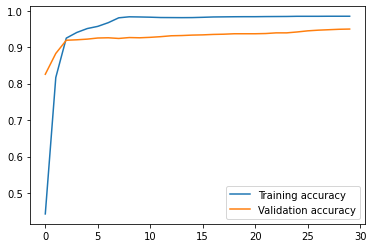

In [ ]:
plt.plot(history.history['accuracy'],label="Training accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation accuracy")
plt.legend()
plt.show()

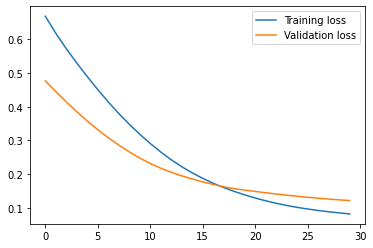

In [ ]:
plt.plot(history.history['loss'],label="Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

## Simple RNN

In [ ]:
X_train, y_train = training_data.to_numpy(), target.to_numpy()

In [ ]:
print(X_train.shape)
print(y_train.shape)

(8143, 5)
(8143, 1)


In [ ]:
from keras.utils.np_utils import to_categorical   

def create_dataset(X, Y, look_back):
    """Convert an array of X, Y values into a dataset matrix for and LSTM"""
    
#    look_back = options.pop('look_back', None)
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i+look_back)]
        dataX.append(a)
        dataY.append(Y[i + look_back])
    dataY = to_categorical(dataY, num_classes=2)
    
    return np.array(dataX), np.array(dataY)

In [ ]:
len(X_train)

8143

In [ ]:
look_back = 30

X_train, y_train = create_dataset(X_train, y_train, look_back)


In [ ]:
print(X_train.shape)
print(y_train.shape)

(8113, 30, 5)
(8113, 2)


In [ ]:

def create_modelRNN():
    model = Sequential()
    model.add(SimpleRNN(16, input_shape=[ look_back, dim_input]))
    model.add(Dense(16,activation='relu',input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout))
    model.add(Dense(2,  activation='softmax'))
    model.compile(loss='binary_crossentropy',optimizer= Adam(lr=0.0001,decay=1e-6),metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
%time

batch_size = 16
dropout = 0.4

dim_input = X_train.shape[2]
dim_output = y_train.shape[1]
model_rnn = create_modelRNN()
history = model_rnn.fit(X_train, y_train, epochs=15, batch_size=batch_size, validation_split=0.2)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 16)                352       
_________________________________________________________________
dense_166 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_58 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_167 (Dense)            (None, 2)                 34        
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
406/406 [==============================] - 11s 26ms/step - loss: 0.8402 - accuracy: 0.3027 - val_loss: 0.7601 - val_accuracy: 0.3309
Epoch 2/15
406/406 [=========================

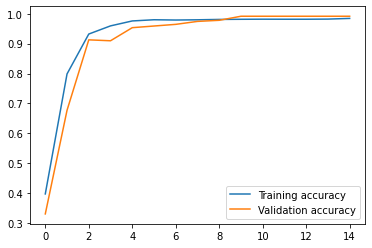

In [ ]:
plt.plot(history.history['accuracy'],label="Training accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation accuracy")
plt.legend()
plt.show()

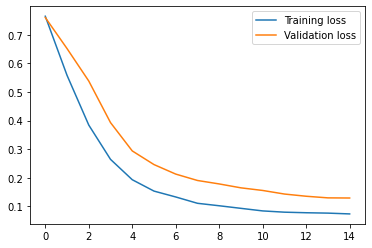

In [ ]:
plt.plot(history.history['loss'],label="Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

## LSTM

In [ ]:
X_train, y_train = training_data.to_numpy(), target.to_numpy()

In [ ]:
look_back = 30

X_train, y_train = create_dataset(X_train, y_train, look_back)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(8113, 30, 5)
(8113, 2)


In [ ]:
def create_modelLSTM():
    model = Sequential()
    model.add(LSTM(16, input_shape=[ look_back, dim_input]))
    model.add(Dense(16,activation='relu',input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout))
    model.add(Dense(2,  activation='softmax'))
    model.compile(loss='binary_crossentropy',optimizer= Adam(lr=0.0001,decay=1e-6),metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
%%time

batch_size = 32
dropout = 0.4

dim_input = X_train.shape[2]
model_lstm = create_modelLSTM()
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 16)                1408      
_________________________________________________________________
dense_150 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_52 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_151 (Dense)            (None, 2)                 34        
Total params: 1,714
Trainable params: 1,714
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
203/203 [==============================] - 3s 7ms/step - loss: 0.6917 - accuracy: 0.5803 - val_loss: 0.6521 - val_accuracy: 0.4442
Epoch 2/10
203/203 [==============================] - 1s 5ms/step - loss: 0.5389 - accuracy: 0.8705 - val_l

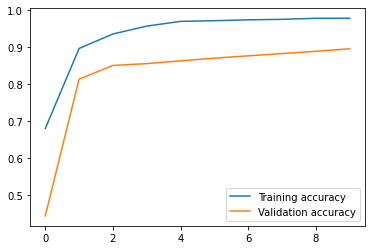

In [ ]:
plt.plot(history.history['accuracy'],label="Training accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation accuracy")
plt.legend()
plt.show()

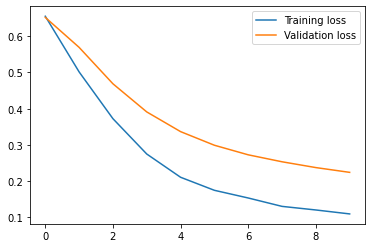

In [ ]:
plt.plot(history.history['loss'],label="Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

## GRU

In [ ]:
from keras import layers

def create_modelGRU():
    model = Sequential()
    model.add(layers.GRU(16, input_shape=[ look_back, dim_input]))
    model.add(Dense(16,activation='relu',input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout))
    model.add(Dense(2,  activation='softmax'))
    model.compile(loss='binary_crossentropy',optimizer= Adam(lr=0.0001,decay=1e-6),metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
%%time

batch_size = 16
dropout = 0.4

dim_input = X_train.shape[2]
dim_output = y_train.shape[1]
model_gru = create_modelGRU()
history = model_gru.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 16)                1104      
_________________________________________________________________
dense_158 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_56 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 2)                 34        
Total params: 1,410
Trainable params: 1,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
406/406 [==============================] - 4s 5ms/step - loss: 0.7559 - accuracy: 0.3525 - val_loss: 0.5370 - val_accuracy: 0.8805
Epoch 2/10
406/406 [==============================] - 2s 5ms/step - loss: 0.5287 - accuracy: 0.9301 - val_l

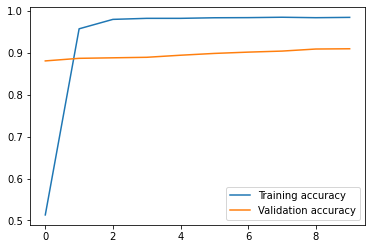

In [ ]:
plt.plot(history.history['accuracy'],label="Training accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation accuracy")
plt.legend()
plt.show()

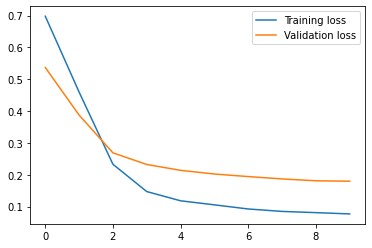

In [ ]:
plt.plot(history.history['loss'],label="Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

## Predictions

In [ ]:
test_data = pd.read_csv("datatest.txt",engine='python')
test_data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [ ]:
len(test_data)

2665

In [ ]:
test_data.drop(columns='date',inplace=True)

In [ ]:
columns_to_scale = ['Temperature','Humidity','Light','CO2','HumidityRatio']
test_set_scaler = StandardScaler().fit(test_data[columns_to_scale].to_numpy())
test_data.loc[:,columns_to_scale] = test_set_scaler.transform(test_data[columns_to_scale].to_numpy())
test_data_occupancy = pd.DataFrame({"Occupancy":test_data['Occupancy']})
test_data.drop(columns='Occupancy',inplace=True)
test_data.head()

,Temperature,Humidity,Light,CO2,HumidityRatio
140,2.204762,0.376814,1.566862,0.106940,1.207540
141,2.222275,0.384202,1.539680,0.145214,1.221461
142,2.233950,0.359575,1.516762,0.176881,1.209161
143,2.226653,0.316478,1.201302,0.194253,1.174140
144,2.257300,0.347262,1.180715,0.208776,1.211522


In [ ]:
len(test_data)

2665

#### Get predictions from our model

In [ ]:
def predict(method, model, test_data, test_labels):
  predictions = model.predict_classes(test_data)
  logits = model.predict(test_data)
  compare = pd.DataFrame({"test_data": test_labels,"predictions":predictions})
  print(f"******{method}*****")
  print(f"f1_score = {  f1_score(compare['test_data'], compare['predictions'])   }")
  print(f"precison_score = {  precision_score(compare['test_data'], compare['predictions'])  }")
  print(f"recall_score = {recall_score(compare['test_data'], compare['predictions'])}")
  print(f"roc_auc_score = {roc_auc_score(test_labels, logits[:, 1])}")
  print(classification_report(test_labels, compare['predictions']))
  return compare

In [ ]:
y_pred = clf.predict(test_data)
y_proba = clf.predict_proba(test_data)
print(f"******Logistic regression*****")
print(f"Precison = {precision_score( test_data_occupancy['Occupancy'].values, y_pred)} ")
print(f"Recall = {recall_score( test_data_occupancy['Occupancy'].values, y_pred)}")
print(f"F1 = {f1_score( test_data_occupancy['Occupancy'].values, y_pred)}")
print(f"roc_auc_score = {roc_auc_score(test_data_occupancy['Occupancy'].values, y_proba[:, 1])}")
print(classification_report(test_data_occupancy['Occupancy'].values, y_pred ))

******Logistic regression*****
Precison = 0.9696132596685083 
Recall = 0.7222222222222222
F1 = 0.8278301886792453
roc_auc_score = 0.9919494213646606
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1693
           1       0.97      0.72      0.83       972

    accuracy                           0.89      2665
   macro avg       0.92      0.85      0.87      2665
weighted avg       0.90      0.89      0.89      2665



In [ ]:
compare_fc = predict('Fully connected', model_fc, test_data, test_data_occupancy['Occupancy'].values)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


******Fully connected*****
f1_score = 0.9221810481736368
precison_score = 0.9498364231188658
recall_score = 0.8960905349794238
roc_auc_score = 0.9901591885250086
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1693
           1       0.95      0.90      0.92       972

    accuracy                           0.94      2665
   macro avg       0.95      0.93      0.94      2665
weighted avg       0.94      0.94      0.94      2665



In [ ]:
look_back = 30
X_test, y_test = create_dataset(test_data.to_numpy(), test_data_occupancy.to_numpy(), look_back)

In [ ]:
compare_rnn = predict('Simple RNN', model_rnn, X_test, test_data_occupancy['Occupancy'].values[: -look_back])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


******Simple RNN*****
f1_score = 0.9386666666666666
precison_score = 0.9431939978563773
recall_score = 0.9341825902335457
roc_auc_score = 0.9778681544965344
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1693
           1       0.94      0.93      0.94       942

    accuracy                           0.96      2635
   macro avg       0.95      0.95      0.95      2635
weighted avg       0.96      0.96      0.96      2635



In [ ]:
look_back = 30
X_test, y_test = create_dataset(test_data.to_numpy(), test_data_occupancy.to_numpy(), look_back)

In [ ]:
X_test.shape

(2635, 30, 5)

In [ ]:
compare_lstm = predict('LSTM', model_lstm, X_test, test_data_occupancy['Occupancy'].values[: -look_back])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


******LSTM*****
f1_score = 0.9543786051389617
precison_score = 0.9430051813471503
recall_score = 0.9660297239915074
roc_auc_score = 0.9796639842087376
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1693
           1       0.94      0.97      0.95       942

    accuracy                           0.97      2635
   macro avg       0.96      0.97      0.96      2635
weighted avg       0.97      0.97      0.97      2635



In [ ]:
compare_gru= predict('GRU', model_gru, X_test, test_data_occupancy['Occupancy'].values[: -30])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


******GRU*****
f1_score = 0.9377328366152208
precison_score = 0.9402347918890075
recall_score = 0.935244161358811
roc_auc_score = 0.9799285931956615
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1693
           1       0.94      0.94      0.94       942

    accuracy                           0.96      2635
   macro avg       0.95      0.95      0.95      2635
weighted avg       0.96      0.96      0.96      2635



In [ ]:
model_lstm.save('model_lstm.h5')

In [ ]:
model_rnn.save('model_rnn.h5')

In [ ]:
model_fc.save('model_fc.h5')

In [ ]:
model_gru.save('model_gru.h5')

## Graphics

In [ ]:
test = pd.read_csv("datatest.txt",engine='python')
test = test.iloc[:-30,:]

In [ ]:
test['Date']=pd.to_datetime(test['date']).dt.date
test['Time']=pd.to_datetime(test['date']).dt.time
test.drop(columns='date',inplace=True)
test=test.set_index(test['Date'])
test.drop(columns='Date',inplace=True)
test.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Time
Date,,,,,,,
2015-02-02,23.7000,26.272,585.200000,749.200000,0.004764,1,14:19:00
2015-02-02,23.7180,26.290,578.400000,760.400000,0.004773,1,14:19:59
2015-02-02,23.7300,26.230,572.666667,769.666667,0.004765,1,14:21:00
2015-02-02,23.7225,26.125,493.750000,774.750000,0.004744,1,14:22:00
2015-02-02,23.7540,26.200,488.600000,779.000000,0.004767,1,14:23:00


In [ ]:
test['Logistic Regression'] = y_pred[:-30]

In [ ]:
test['Fully connected'] = compare_fc['predictions'].to_numpy()[:-30]

In [ ]:
test['Simple RNN'] = compare_rnn['predictions'].to_numpy()

In [ ]:
test['LSTM'] = compare_lstm['predictions'].to_numpy()

In [ ]:
test['GRU'] = compare_gru['predictions'].to_numpy()

In [ ]:
compare_fc['predictions']

0       1
1       1
2       1
3       0
4       0
       ..
2660    1
2661    1
2662    1
2663    1
2664    1
Name: predictions, Length: 2665, dtype: int64

In [ ]:
test

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Time,Fully connected,Simple RNN,LSTM,GRU,Logistic Regression
Date,,,,,,,,,,,,
2015-02-02,23.700000,26.272000,585.200000,749.200000,0.004764,1,14:19:00,1,1,1,1,0
2015-02-02,23.718000,26.290000,578.400000,760.400000,0.004773,1,14:19:59,1,1,1,1,0
2015-02-02,23.730000,26.230000,572.666667,769.666667,0.004765,1,14:21:00,1,1,1,1,0
2015-02-02,23.722500,26.125000,493.750000,774.750000,0.004744,1,14:22:00,0,1,1,1,0
2015-02-02,23.754000,26.200000,488.600000,779.000000,0.004767,1,14:23:00,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-02-04,23.666667,26.066667,746.333333,1109.000000,0.004717,1,10:08:59,1,1,1,1,1
2015-02-04,23.700000,26.120000,737.800000,1119.000000,0.004736,1,10:09:59,1,1,1,1,1
2015-02-04,23.718000,26.100000,745.000000,1123.400000,0.004738,1,10:11:00,1,1,1,1,1


(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000., 40000.]), <a list of 10 Text major ticklabel objects>)

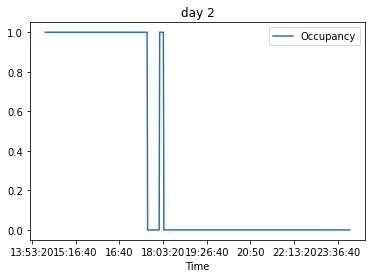

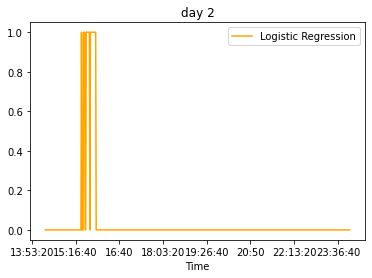

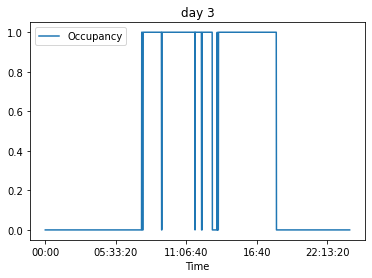

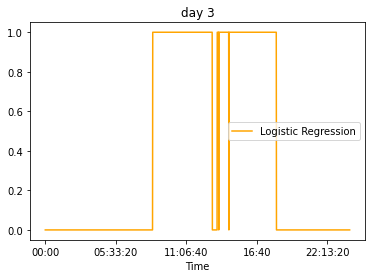

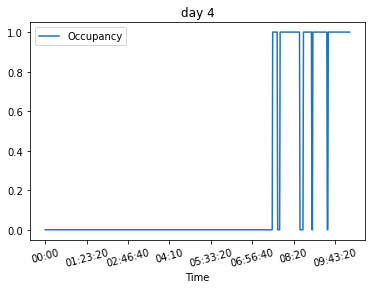

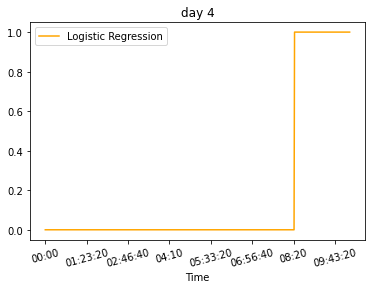

In [ ]:
day2 = test.loc[datetime.date(year=2015,month=2,day=2)]
day3 = test.loc[datetime.date(year=2015,month=2,day=3)]
day4 = test.loc[datetime.date(year=2015,month=2,day=4)]


day2.plot('Time','Occupancy', title = 'day 2')
day2.plot('Time','Logistic Regression', title = 'day 2', color='orange')
day3.plot('Time','Occupancy', title = 'day 3')
day3.plot('Time','Logistic Regression', title = 'day 3', color='orange')
day4.plot('Time','Occupancy', title = 'day 4')
plt.xticks(rotation=15)
day4.plot('Time','Logistic Regression', title = 'day 4', color='orange')
plt.xticks(rotation=15)

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000., 40000.]), <a list of 10 Text major ticklabel objects>)

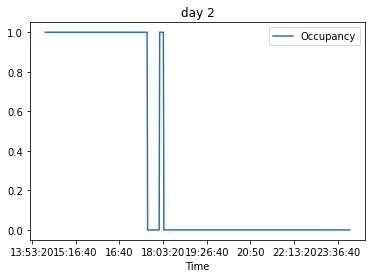

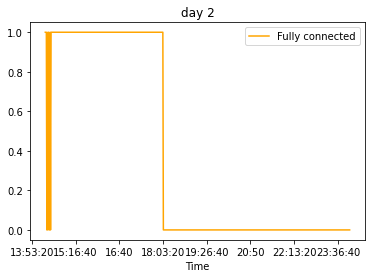

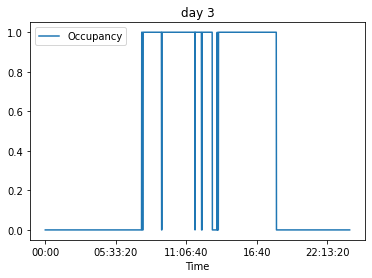

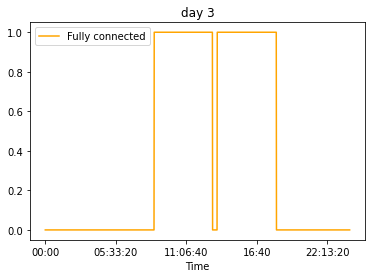

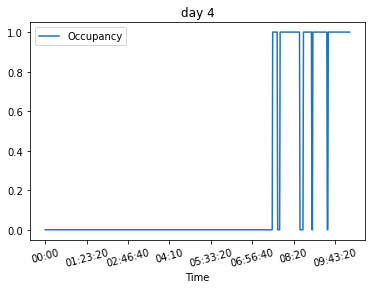

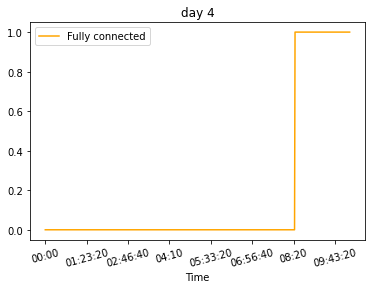

In [ ]:
day2 = test.loc[datetime.date(year=2015,month=2,day=2)]
day3 = test.loc[datetime.date(year=2015,month=2,day=3)]
day4 = test.loc[datetime.date(year=2015,month=2,day=4)]


day2.plot('Time','Occupancy', title = 'day 2')
day2.plot('Time','Fully connected', title = 'day 2', color='orange')
day3.plot('Time','Occupancy', title = 'day 3')
day3.plot('Time','Fully connected', title = 'day 3', color='orange')
day4.plot('Time','Occupancy', title = 'day 4')
plt.xticks(rotation=15)
day4.plot('Time','Fully connected', title = 'day 4', color='orange')
plt.xticks(rotation=15)

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000., 40000.]), <a list of 10 Text major ticklabel objects>)

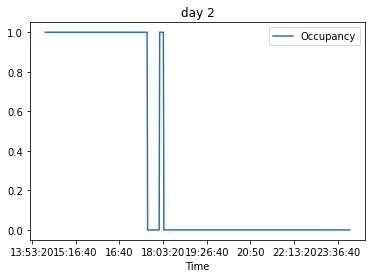

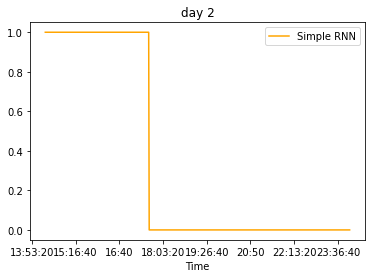

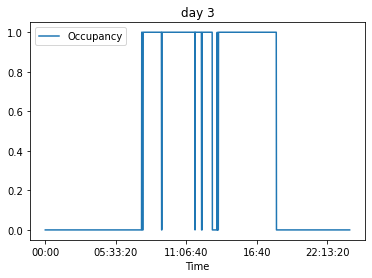

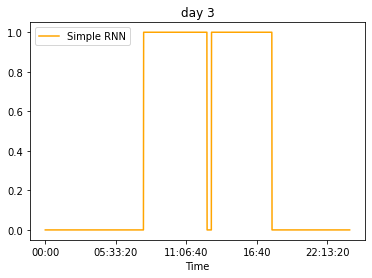

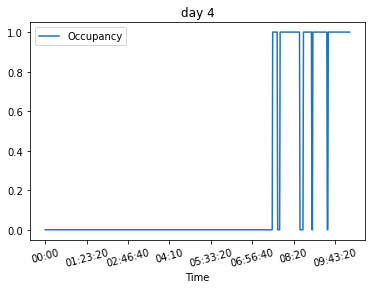

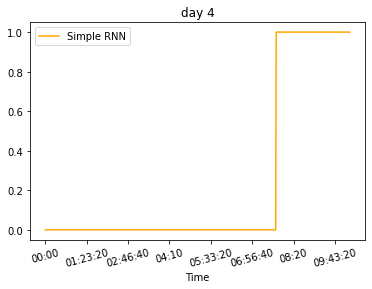

In [ ]:
day2 = test.loc[datetime.date(year=2015,month=2,day=2)]
day3 = test.loc[datetime.date(year=2015,month=2,day=3)]
day4 = test.loc[datetime.date(year=2015,month=2,day=4)]


day2.plot('Time','Occupancy', title = 'day 2')
day2.plot('Time','Simple RNN', title = 'day 2', color='orange')
day3.plot('Time','Occupancy', title = 'day 3')
day3.plot('Time','Simple RNN', title = 'day 3', color='orange')
day4.plot('Time','Occupancy', title = 'day 4')
plt.xticks(rotation=15)
day4.plot('Time','Simple RNN', title = 'day 4', color='orange')
plt.xticks(rotation=15)

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000., 40000.]), <a list of 10 Text major ticklabel objects>)

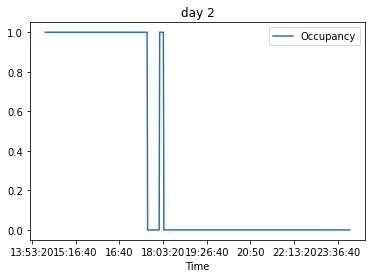

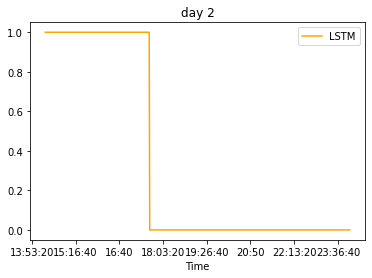

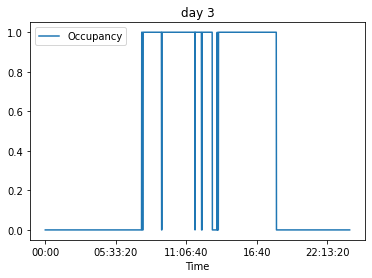

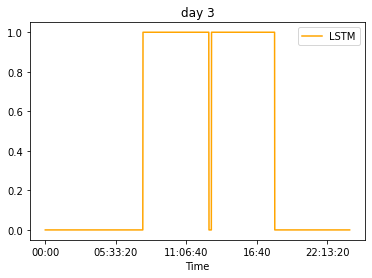

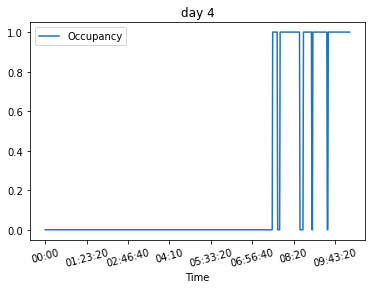

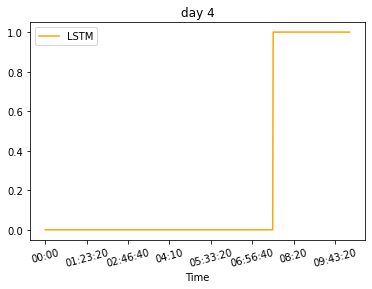

In [ ]:
day2 = test.loc[datetime.date(year=2015,month=2,day=2)]
day3 = test.loc[datetime.date(year=2015,month=2,day=3)]
day4 = test.loc[datetime.date(year=2015,month=2,day=4)]


day2.plot('Time','Occupancy', title = 'day 2')
day2.plot('Time','LSTM', title = 'day 2', color='orange')
day3.plot('Time','Occupancy', title = 'day 3')
day3.plot('Time','LSTM', title = 'day 3', color='orange')
day4.plot('Time','Occupancy', title = 'day 4')
plt.xticks(rotation=15)
day4.plot('Time','LSTM', title = 'day 4', color='orange')
plt.xticks(rotation=15)

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000., 40000.]), <a list of 10 Text major ticklabel objects>)

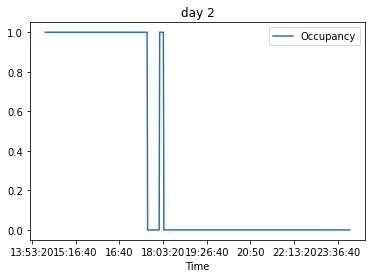

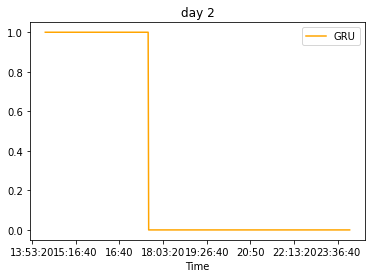

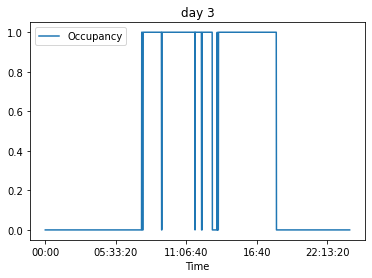

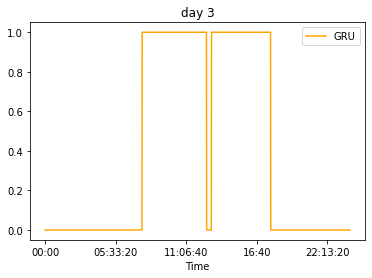

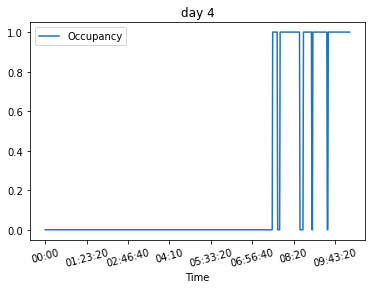

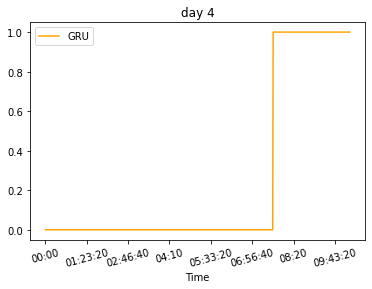

In [ ]:
day2 = test.loc[datetime.date(year=2015,month=2,day=2)]
day3 = test.loc[datetime.date(year=2015,month=2,day=3)]
day4 = test.loc[datetime.date(year=2015,month=2,day=4)]


day2.plot('Time','Occupancy', title = 'day 2')
day2.plot('Time','GRU', title = 'day 2', color='orange')
day3.plot('Time','Occupancy', title = 'day 3')
day3.plot('Time','GRU', title = 'day 3', color='orange')
day4.plot('Time','Occupancy', title = 'day 4')
plt.xticks(rotation=15)
day4.plot('Time','GRU', title = 'day 4', color='orange')
plt.xticks(rotation=15)

In [ ]:
test.to_csv('result.csv')

In [ ]:
d = pd.read_csv('result.csv')

In [ ]:
d.head()

,Date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,Time,Fully connected,Simple RNN,LSTM,GRU,Logistic Regression
0,2015-02-02,23.7000,26.272,585.200000,749.200000,0.004764,1,14:19:00,1,1,1,1,0
1,2015-02-02,23.7180,26.290,578.400000,760.400000,0.004773,1,14:19:59,1,1,1,1,0
2,2015-02-02,23.7300,26.230,572.666667,769.666667,0.004765,1,14:21:00,1,1,1,1,0
3,2015-02-02,23.7225,26.125,493.750000,774.750000,0.004744,1,14:22:00,0,1,1,1,0
4,2015-02-02,23.7540,26.200,488.600000,779.000000,0.004767,1,14:23:00,0,1,1,1,0
